In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, fbeta_score, mean_squared_error, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import xgboost
import time

In [2]:
df = pd.read_csv("../data/weatherAUS.csv")

In [3]:
np.eye(5)[2]

array([0., 0., 1., 0., 0.])

In [4]:
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


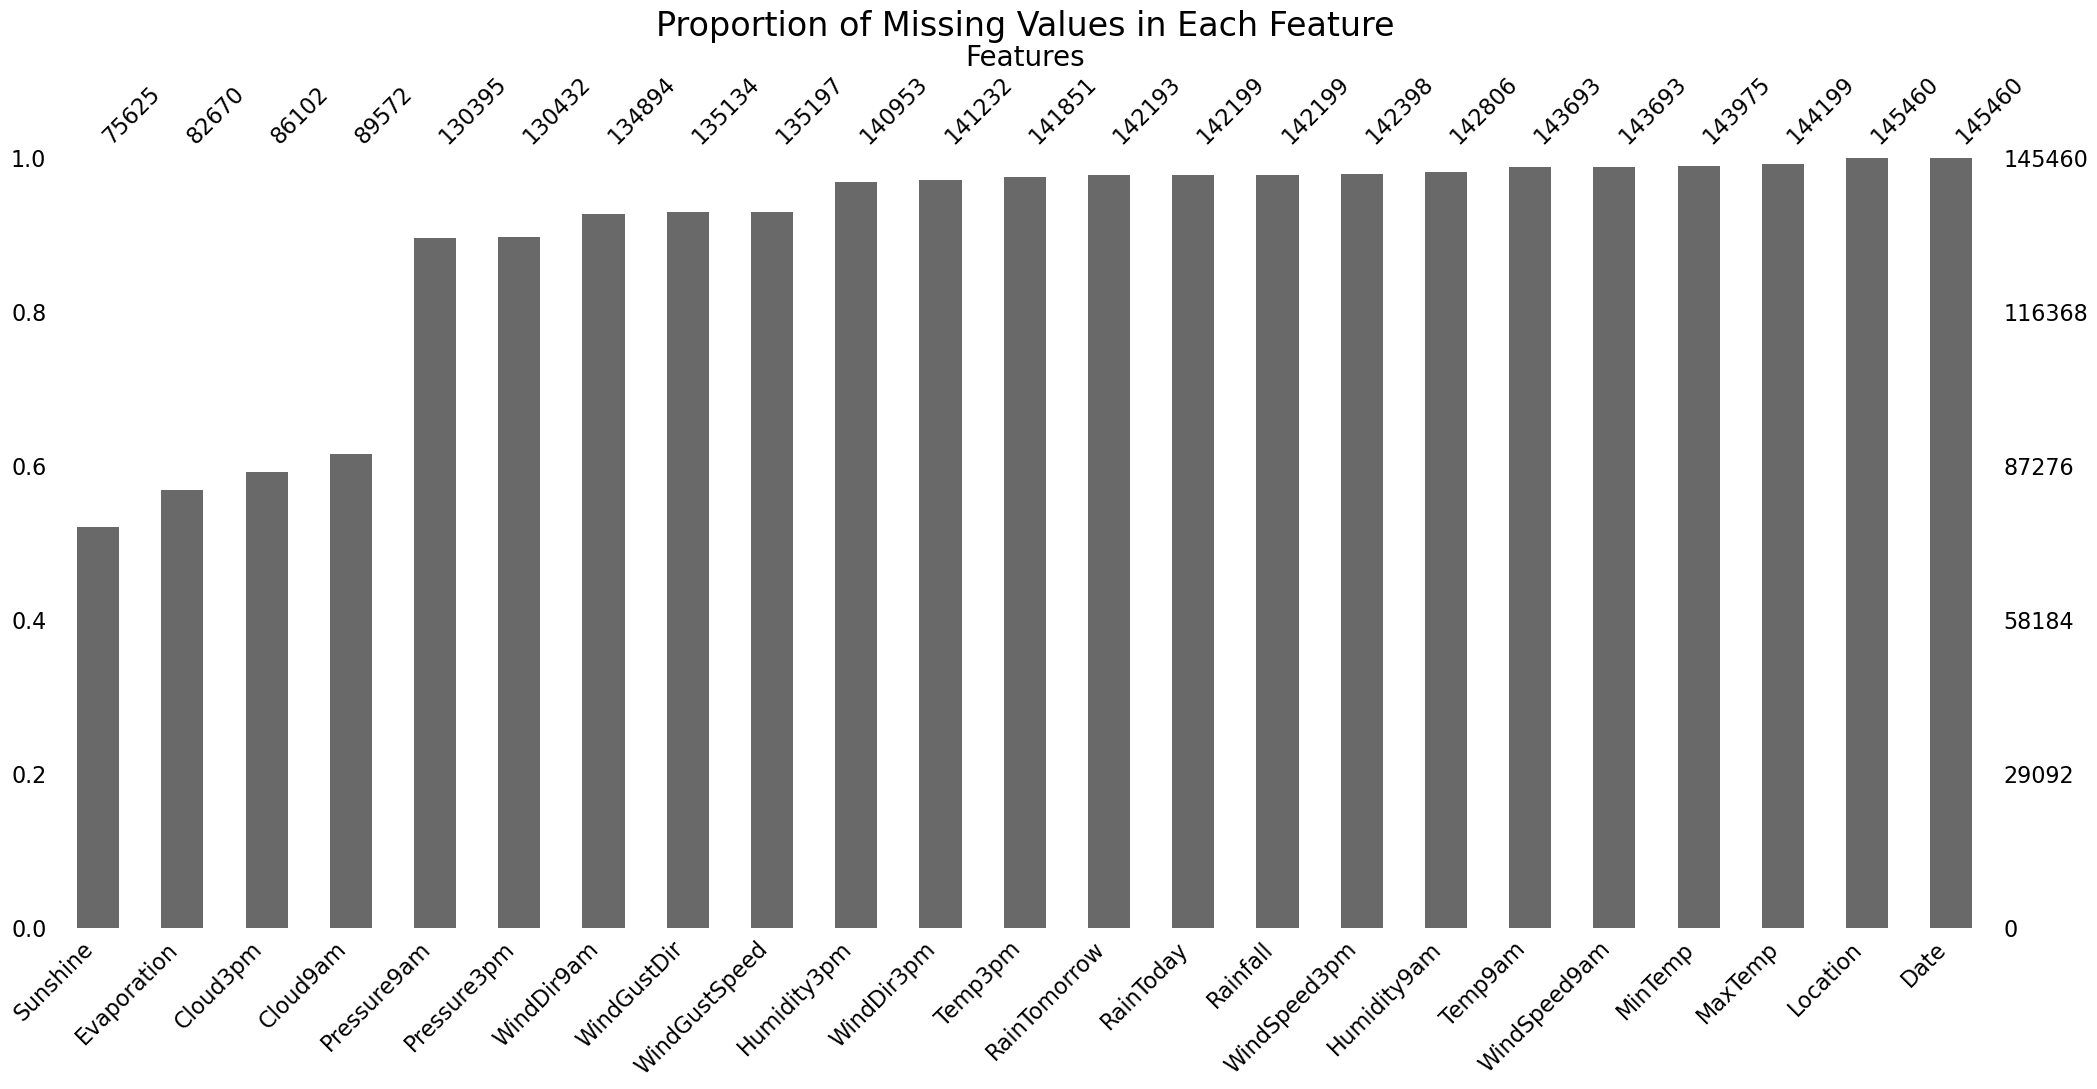

In [5]:
msno.bar(df, sort='ascending')

# Add a title with larger font size
plt.title('Proportion of Missing Values in Each Feature', fontsize=24)

# Adjust x and y axis labels font size
plt.xlabel('Features', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

# Adjust tick parameters for both axes
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('../figures/missing_values.png', bbox_inches='tight')

In [6]:
df.shape

(145460, 23)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [8]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

data dimensions: (145460, 23)
fraction of missing values in features:
MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64


In [9]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


[[<Axes: title={'center': 'MinTemp'}> <Axes: title={'center': 'MaxTemp'}>
  <Axes: title={'center': 'Rainfall'}>
  <Axes: title={'center': 'Evaporation'}>]
 [<Axes: title={'center': 'Sunshine'}>
  <Axes: title={'center': 'WindGustSpeed'}>
  <Axes: title={'center': 'WindSpeed9am'}>
  <Axes: title={'center': 'WindSpeed3pm'}>]
 [<Axes: title={'center': 'Humidity9am'}>
  <Axes: title={'center': 'Humidity3pm'}>
  <Axes: title={'center': 'Pressure9am'}>
  <Axes: title={'center': 'Pressure3pm'}>]
 [<Axes: title={'center': 'Cloud9am'}>
  <Axes: title={'center': 'Cloud3pm'}>
  <Axes: title={'center': 'Temp9am'}> <Axes: title={'center': 'Temp3pm'}>]]


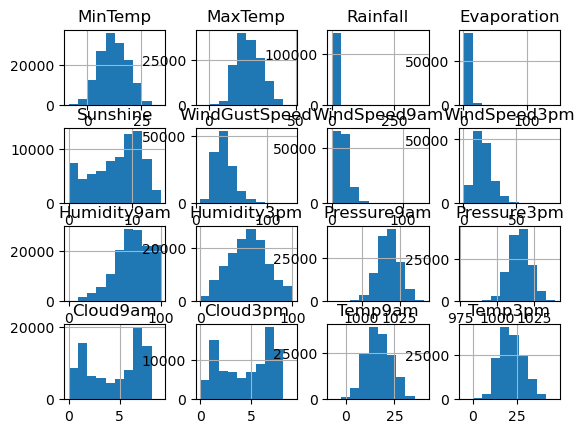

In [10]:
print(df.hist())

In [11]:
# check duplicated rows
df[df.duplicated()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


In [12]:
# Categorical variable
categorical = [var for var in df.columns if df[var].dtype=='O']
print(categorical)
for name in categorical:
    print("=========="+name+"=============")
    print(df[name].value_counts())

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
==========Date=============
Date
2013-11-12    49
2014-09-01    49
2014-08-23    49
2014-08-24    49
2014-08-25    49
              ..
2007-11-29     1
2007-11-28     1
2007-11-27     1
2007-11-26     1
2008-01-31     1
Name: count, Length: 3436, dtype: int64
==========Location=============
Location
Canberra            3436
Sydney              3344
Darwin              3193
Melbourne           3193
Brisbane            3193
Adelaide            3193
Perth               3193
Hobart              3193
Albany              3040
MountGambier        3040
Ballarat            3040
Townsville          3040
GoldCoast           3040
Cairns              3040
Launceston          3040
AliceSprings        3040
Bendigo             3040
Albury              3040
MountGinini         3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
Woomera             3009
Nurioo

In [13]:
perc_missing_per_ftr = df[categorical].isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
WindGustDir     0.070989
WindDir9am      0.072639
WindDir3pm      0.029066
RainToday       0.022419
RainTomorrow    0.022460
dtype: float64


There are five variables with missing values: WindGustDir, WindDir9am, WindDir3am, RainToday and RainTomorrow. We will fix this problem in feature egineering section.

In [14]:
## taget variable RainTomorrow
df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [15]:
df['RainTomorrow'].isnull().sum()

3267

Without the target variable, observations cannot provide any useful information for a supervised machine learning model. Therefore, we will drop all rows with missing target variables.

In [16]:
# drop the row with missing target variable
df = df[pd.notna(df['RainTomorrow'])]

In [17]:
df['RainTomorrow'].isnull().sum()

0

In [18]:
perc_missing_per_ftr = df[categorical].isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
WindGustDir    0.065615
WindDir9am     0.070418
WindDir3pm     0.026570
RainToday      0.009888
dtype: float64


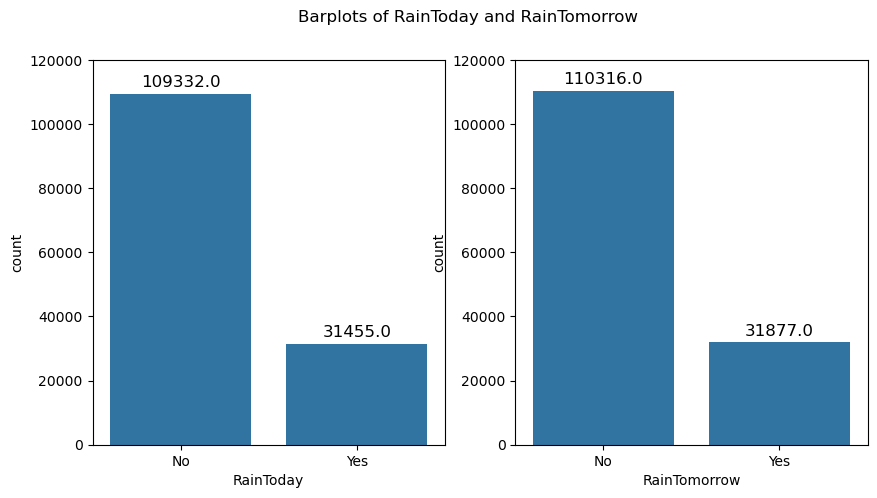

In [19]:
fig, ax =plt.subplots(1,2, figsize=(10, 5))
sns.countplot(data=df,x='RainToday',ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                   textcoords='offset points')
ax[0].set_ylim(0, 120000)
sns.countplot(data=df,x='RainTomorrow',ax=ax[1])
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                   textcoords='offset points')
ax[1].set_ylim(0, 120000)
fig.suptitle("Barplots of RainToday and RainTomorrow")
plt.savefig('../figures/bar_plot.png', bbox_inches='tight')

RainTomorrow     No    Yes
RainToday                 
No            92728  16604
Yes           16858  14597
RainTomorrow    No   Yes
WindGustDir             
E             7721  1350
ENE           6704  1288
ESE           6105  1200
N             6581  2452
NE            5741  1319
NNE           4952  1481
NNW           4698  1863
NW            5719  2284
S             6932  2017
SE            7576  1733
SSE           7238  1755
SSW           6713  1897
SW            6993  1804
W             7173  2607
WNW           5791  2275
WSW           6816  2085
RainTomorrow        No       Yes
WindGustDir                     
E             0.851174  0.148826
ENE           0.838839  0.161161
ESE           0.835729  0.164271
N             0.728551  0.271449
NE            0.813173  0.186827
NNE           0.769781  0.230219
NNW           0.716049  0.283951
NW            0.714607  0.285393
S             0.774612  0.225388
SE            0.813836  0.186164
SSE           0.804848  0.195152
SSW          

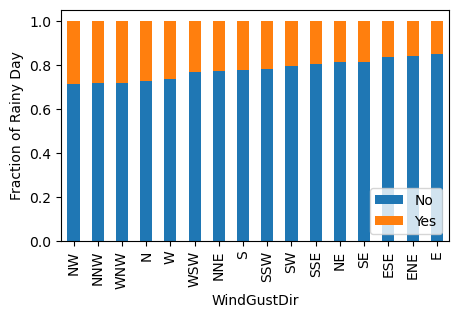

In [20]:
# Grouping and counting occurrences
count_matrix = df.groupby(['RainToday', 'RainTomorrow']).size().unstack()
print(count_matrix)
count_matrix = df.groupby(['WindGustDir', 'RainTomorrow']).size().unstack()
print(count_matrix)
# Normalizing the counts by rows
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
print(count_matrix_norm)

# Sorting by the proportion of 'Yes' in RainTomorrow
count_matrix_norm = count_matrix_norm.sort_values(by='Yes', ascending=False)

# Plotting the sorted data
count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.ylabel('Fraction of Rainy Day')
plt.legend(loc=4)
plt.savefig("../figures/windd_raint_cc.png")
plt.show()

In [21]:
## Date
df['Date'].nunique()

3436

There are 3436 unique value in Date column, so we consider to convert this column to year, month and day.

In [22]:
df['Date'] = pd.to_datetime(df['Date'])

In [23]:
# add year column
df['Year'] = df['Date'].dt.year

In [24]:
# add month column
df['Month'] = df['Date'].dt.month

In [25]:
# add day column
df['Day'] = df['Date'].dt.day

In [26]:
# drop the original Date column since we already have the date information in new columns
df.drop('Date', axis=1, inplace = True)

In [27]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


In [28]:
##. Location
print(df['Location'].value_counts())

Location
Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Launceston          3028
Ballarat            3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
Penrith             2964
NorfolkIsland       2964
SalmonGums          2955
Newcastle           2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek   

In [29]:
df['Location'].isnull().sum(axis=0)

0

There are no missing value in Location column.

In [30]:
df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [31]:
## WindGustDir
df['WindGustDir'].value_counts()

WindGustDir
W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: count, dtype: int64

In [32]:
df['WindGustDir'].isnull().sum()

9330

There are 9330 missing values in the WindGustDir column. We will use a Simple Imputer to handle the missing values by replacing them with the category 'other'. Also, the WindGustDir is a categorical variablek and we will use onehot encoder to preprocess the column.

In [33]:
## WindDir9am
df['WindDir9am'].value_counts()

WindDir9am
N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: count, dtype: int64

In [34]:
df['WindDir9am'].isnull().sum()

10013




There are 10013 missing values in the WindDir9am column. We will use a Simple Imputer to handle the missing values by replacing them with the category 'other'. Also, the WindDir9am is a categorical variablek and we will use onehot encoder to preprocess the column.

In [35]:
## WindDir3pm
df['WindDir3pm'].value_counts()

WindDir3pm
SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: count, dtype: int64

In [36]:
df['WindDir3pm'].isnull().sum()

3778

There are 3778 missing values in the WindDir3am column. We will use a Simple Imputer to handle the missing values by replacing them with the category 'other'. Also, the WindDir3am is a categorical variablek and we will use onehot encoder to preprocess the column.


In [37]:
## RainToday
df['RainToday'].value_counts()

RainToday
No     109332
Yes     31455
Name: count, dtype: int64

In [38]:
df['RainToday'].isnull().sum()

1406

There are 1406 missing values in the RainToday column. We will use a Simple Imputer to handle the missing values by replacing them with the category 'other'. Also, the RainToday is a categorical variablek and we will use onehot encoder to preprocess the column.


In [39]:
df['Cloud3pm'].dtype

dtype('float64')

In [40]:
df.shape

(142193, 25)

In [41]:
# Continous variable
continuous = [var for var in df.columns if df[var].dtype== 'float64']
print(continuous)


['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [42]:
perc_missing_per_ftr = df[continuous].isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustSpeed    0.065193
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
dtype: float64


In [43]:
# view summary statistics of the continuous variables
print(round(df[continuous].describe()),2)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  141556.0  141871.0  140787.0      81350.0   74377.0       132923.0   
mean       12.0      23.0       2.0          5.0       8.0           40.0   
std         6.0       7.0       8.0          4.0       4.0           14.0   
min        -8.0      -5.0       0.0          0.0       0.0            6.0   
25%         8.0      18.0       0.0          3.0       5.0           31.0   
50%        12.0      23.0       0.0          5.0       8.0           39.0   
75%        17.0      28.0       1.0          7.0      11.0           48.0   
max        34.0      48.0     371.0        145.0      14.0          135.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count      140845.0      139563.0     140419.0     138583.0     128179.0   
mean           14.0          19.0         69.0         51.0       1018.0   
std             9.0           9.0         19.0         21.0          7.0   
mi

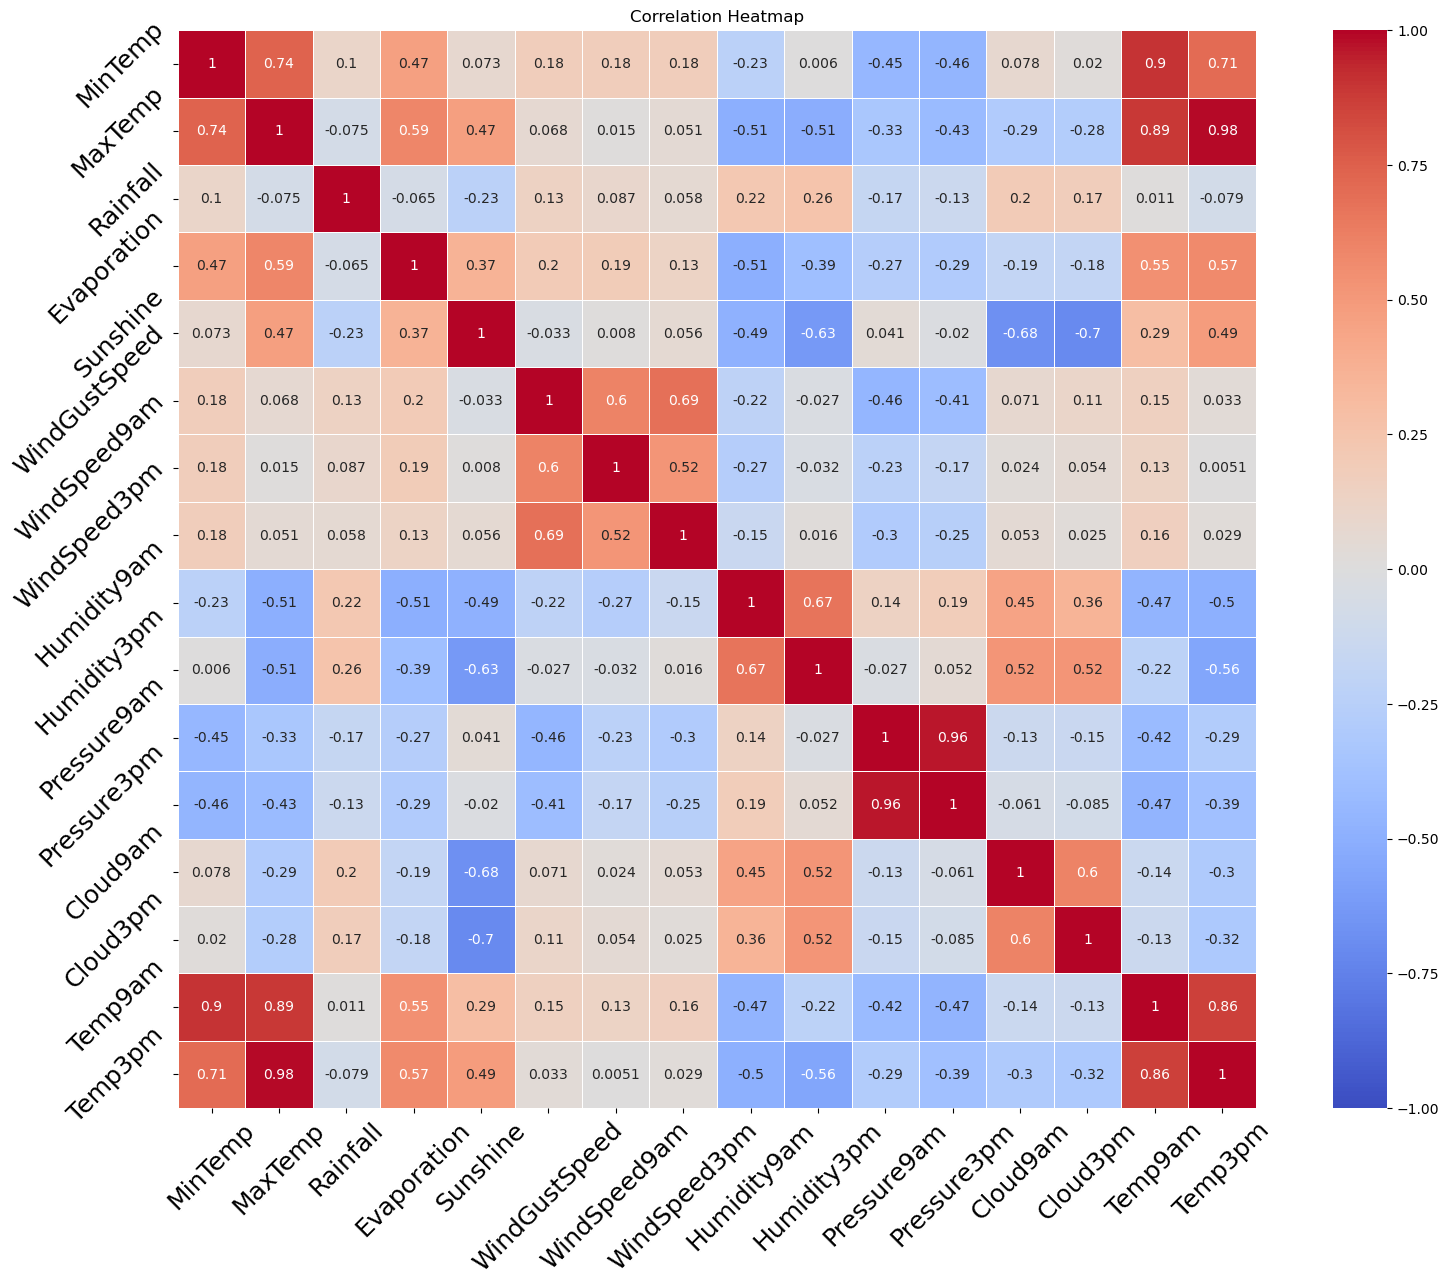

In [44]:
corr_matrix = df[continuous].corr(method='pearson', min_periods=1, numeric_only=False)
plt.figure(figsize=(20, 14)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(fontsize=18, rotation=45)  # 使x轴刻度旋转45度
plt.yticks(fontsize=18, rotation=45)
plt.savefig('../figures/correlation.png', bbox_inches='tight')
plt.show()

For the above correlation plot, we can conclude that:
1. Variable MinTemp and Temp9am are highly postive correlated. (with a positive correlation value = 0.9).
2. Variable MinTemp and MaxTemp are highly postive correlated. (with a positive correlation value = 0.74).
3. Variable MinTemp and Temp3pm are highly postive correlated. (with a positive correlation value = 0.71).
4. Variable MaxTemp and Temp9am are highly postive correlated. (with a positive correlation value = 0.89).
5. Variable MaxTemp and Temp3pm are highly postive correlated. (with a positive correlation value = 0.98).
6. Variable Pressure9am and Pressure3pm are highly postive correlated. (with a positive correlation value = 0.96).
7. Variable Temp9am and Temp3pm are highly postive correlated. (with a positive correlation value = 0.89).

Due to the high correlation value, we decide to drop variable Temp9am, Temp3pm and Pressure3pm

In [45]:
num_var = ['MinTemp','MaxTemp','Temp9am','Temp3pm','Pressure9am', 'Pressure3pm']

In [46]:
df.drop('Temp9am', axis=1, inplace = True)
df.drop('Temp3pm', axis=1, inplace = True)
df.drop('Pressure3pm', axis=1, inplace = True)

In [47]:
# Continous variable
continuous = [var for var in df.columns if df[var].dtype== 'float64']
print(continuous)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm']


In [48]:
num_ftr = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm','Humidity9am','RainTomorrow']

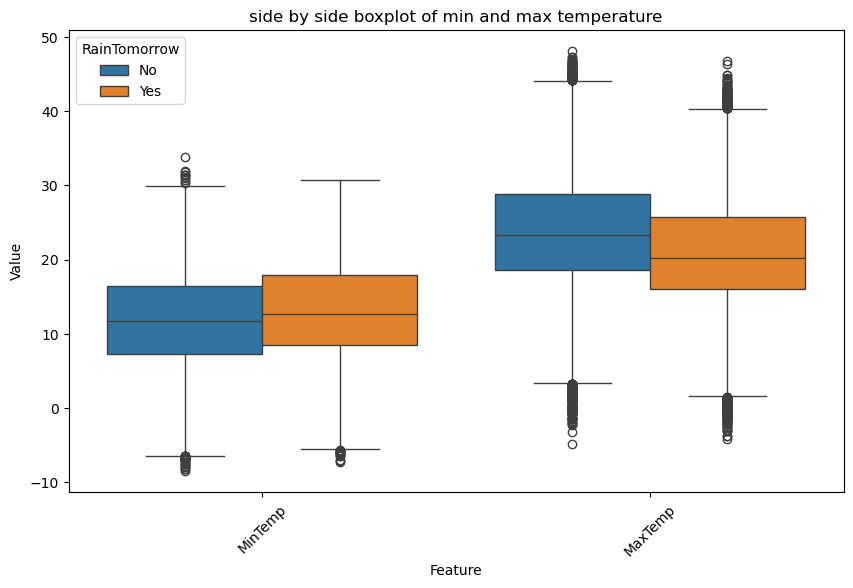

In [49]:
num_ftr = ['MinTemp', 'MaxTemp','RainTomorrow' ]
df_box=pd.melt(df[num_ftr], id_vars=['RainTomorrow'], value_vars=['MinTemp', 'MaxTemp'],
                  var_name='Feature', value_name='Value')
plt.figure(figsize=(10,6))
sns.boxplot(df_box,x='Feature', y='Value', hue='RainTomorrow' )
#df[num_ftr].boxplot(hue='RainTomorrow')
plt.xticks(fontsize=10, rotation=45)  # 使x轴刻度旋转45度
plt.yticks(fontsize=10)
plt.title("side by side boxplot of min and max temperature")
# plt.xlabel('X Label', fontsize=40)
# plt.ylabel('Y Label', fontsize=40)
plt.savefig('../figures/boxplot.png', bbox_inches='tight')

plt.show()

/var/folders/4d/651vb1t15t79s6jcysz6pv140000gn/T/ipykernel_96630/1186673318.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')


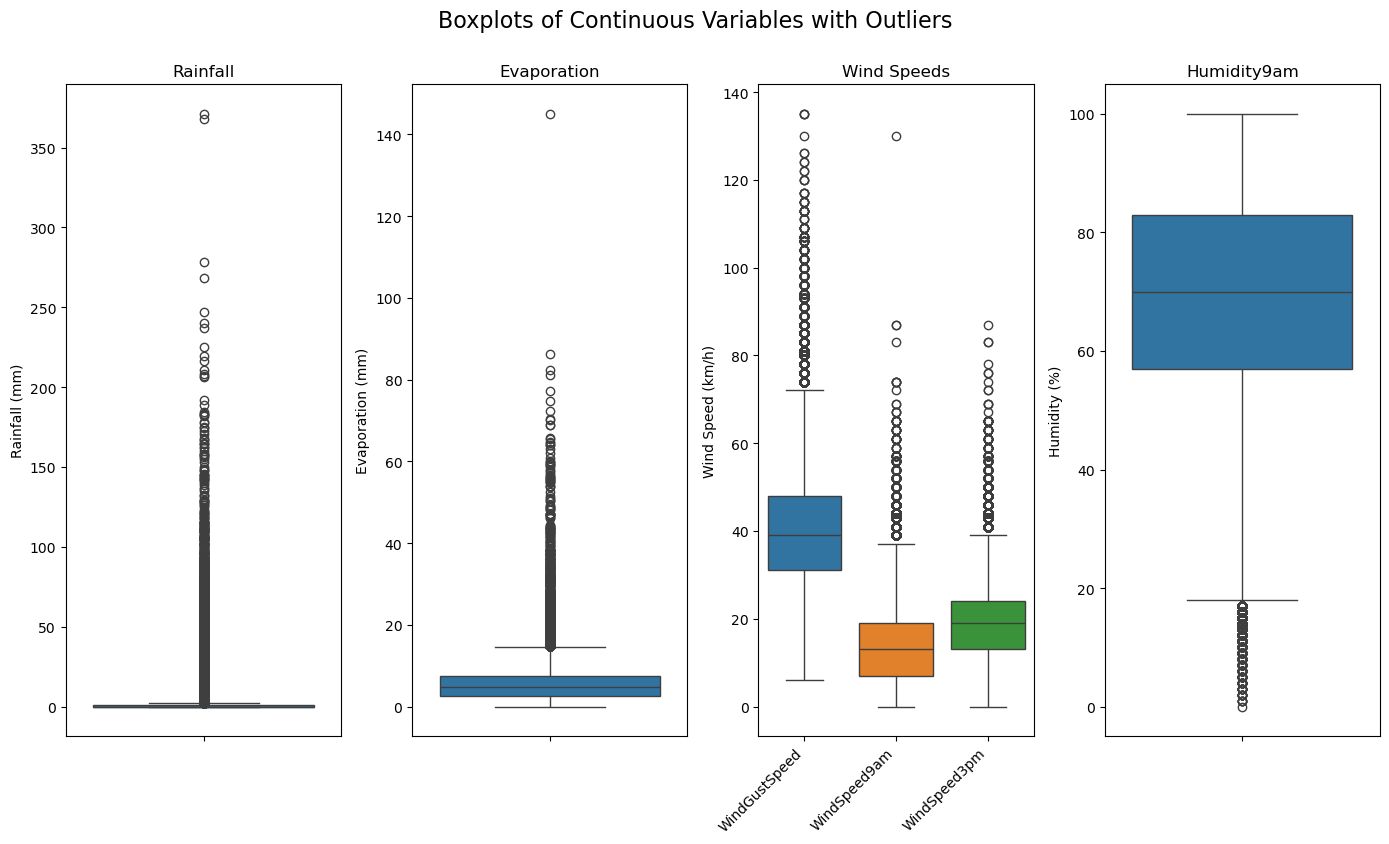

In [50]:
%matplotlib inline
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(14, 8))

# Rainfall boxplot
sns.boxplot(y=df['Rainfall'], ax=axs[0])
axs[0].set_title('Rainfall')
axs[0].set_ylabel('Rainfall (mm)')

# Evaporation boxplot
sns.boxplot(y=df['Evaporation'], ax=axs[1])
axs[1].set_title('Evaporation')
axs[1].set_ylabel('Evaporation (mm)')

# WindSpeed boxplots
sns.boxplot(data=df[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']], ax=axs[2], orient='v')
axs[2].set_title('Wind Speeds')
axs[2].set_ylabel('Wind Speed (km/h)')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

# Humidity boxplot
sns.boxplot(y=df['Humidity9am'], ax=axs[3])
axs[3].set_title('Humidity9am')
axs[3].set_ylabel('Humidity (%)')

# Adjust layout for clarity
plt.tight_layout()
fig.suptitle("Boxplots of Continuous Variables with Outliers", fontsize=16, y=1.05)  # y调整标题位置
# Adjust layout, leaving space for the suptitle
fig.savefig('../figures/boxplot.png')
plt.show()

Upon closer inspection, we found that Rainfall, Evaporation, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am and Pressure9am contain significant outliers.

In [51]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']

In [52]:
random_state = 42
train_size = 0.8
X_other, X_test,y_other, y_test = train_test_split(X,y,train_size = train_size,random_state = random_state)

In [53]:
# preprocess with pipeline and columntransformer
num_ftrs = [var for var in X.columns if X[var].dtype== 'float64']
cat_ftrs = [var for var in X.columns if X[var].dtype== 'O']
print(num_ftrs, cat_ftrs)
# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='other')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

preprocessor = Pipeline(steps=[('preprocessor',preprocessor)])

X_other_prep = preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_test)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm'] ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [54]:
def down_sample_1(n ,df):
    df_sorted = df.sort_values(by=['Year', 'Month', 'Day']).reset_index(drop=True)
    return df_sorted.iloc[-n:]

In [55]:
def xgb_model(X_other,y_other, X_test, y_test, random_state, verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = xgboost.XGBClassifier(n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [100],
                  "seed": [0],
                  "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  #"max_depth": [1,3,10,30,100,],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params,early_stopping_rounds=50)
            eval_set = [(X_val, y_val)]
            clf.fit(X_train, y_train,
                    eval_set=eval_set, verbose=False)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0],early_stopping_rounds=50)
    clf.fit(X_train,y_train,
            eval_set=eval_set, verbose=False)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params, clf.feature_importances_)

def xgb_model_1(X_other,y_other, X_test, y_test,random_state, verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = xgboost.XGBClassifier(n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [1000],
                  "seed": [0],
                  "scale_pos_weight": [1.1],
                  "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  #"max_depth": [1,3,10,30,100,],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]} 

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params,early_stopping_rounds=50)
            eval_set = [(X_val, y_val)]
            clf.fit(X_train, y_train,
                    eval_set=eval_set, verbose=False)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0],early_stopping_rounds=50)
    clf.fit(X_train,y_train,
            eval_set=eval_set, verbose=False)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return accuracy_score(y_test,y_test_pred), fbeta_score(y_test,y_test_pred,beta=1), clf,best_params

def rf_model(X_other,y_other, X_test, y_test, random_state,verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {'n_estimators': [100], 'max_features': ['log2', 'sqrt'],'max_depth': [2,4,8,16,32]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params, clf.feature_importances_)

def knn_model(X_other,y_other, X_test, y_test,random_state, verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = KNeighborsClassifier(n_jobs=-1)
    
    # find the best parameter set
    param_grid = {'n_neighbors':[2,4,8,16,32,64]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params)

def svc_model(X_other,y_other, X_test, y_test, random_state,verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = SVC(random_state=random_state)
    
    # find the best parameter set
    param_grid = {
    'C': np.logspace(-2,2,num=5),              # Regularization parameter
    'gamma':np.logspace(-2,2,num=5),           # Gamma values for rbf/poly/sigmoid kernels
}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params)

def l1_model(X_other,y_other, X_test, y_test,random_state, verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(solver='saga', penalty='l1',n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {
    'C': 1/np.logspace(-2,2,num=5)              # Regularization parameter
}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params)

def l2_model(X_other,y_other, X_test, y_test, random_state,verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(solver='saga', penalty='l2',n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {
    'C': 1/np.logspace(-2,2,num=5)              # Regularization parameter
}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params)

def ela_model(X_other,y_other, X_test, y_test,random_state, verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 3
    this_cv = TimeSeriesSplit(n_splits=n_splits)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(solver='saga', penalty='elasticnet',n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {
    'C': 1/np.logspace(-2,2,num=5),              # Regularization parameter
    'l1_ratio': np.linspace(0,1,5)
}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    return (accuracy_score(y_test,y_test_pred), y_test_pred,best_params)



def reduced_feature_model(X_other, y_other, X_test, y_test, model,random_state):
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    best_params = {}
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                
                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_other = pd.DataFrame()
        sub_y_other = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_other = X_other[X_other.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_other = sub_X_other.dropna()
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_y_other = y_other.iloc[sub_X_other.index]
        
        # run XGB
        sub_y_test_pred = model(sub_X_other, sub_y_other, sub_X_test, sub_y_test,random_state=random_state, verbose=0)
        best_params[i] = sub_y_test_pred[2]
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   accuracy:',accuracy_score(sub_y_test,sub_y_test_pred))
        # print('number of data points in test set', sub_X_test.shape)
        # print('number of data points in val set', sub_X_CV.shape)
        # print('number of data points in train set', sub_X_train.shape)

        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_acc = accuracy_score(y_test,all_y_test_pred)
    total_R2 =  fbeta_score(y_test,all_y_test_pred,beta=1)
    return total_acc, total_R2, best_params

In [58]:
# 1. down sample 
random_state = 42
train_size = 0.8
down_sampled_df = down_sample_1(20000,df)
X_d = down_sampled_df.drop(['RainTomorrow'], axis=1)
y_d = down_sampled_df['RainTomorrow']
# X_train_d, y_train_d, X_val_d, y_val_d, X_test_d, y_test_d = basic_split(X_d, y_d, train_size, val_size, test_size, random_state = 42)
# # 2. preprocess down_sampled df
# le = LabelEncoder()
# X_train_prep_d = preprocessor.fit_transform(X_train_d)
# X_val_prep_d = preprocessor.tran2sform(X_val_d)
# X_test_prep_d = preprocessor.transform(X_test_d)
# y_train_d = le.fit_transform(y_train_d)
# y_val_d = le.transform(y_val_d)
# y_test_d = le.transform(y_test_d)
# # 3. timeseries split the dataset
# this_cv = TimeSeriesSplit(n_splits=5)
acc = []
total_R2 = []
acc_dict = {}
fbeta_dict = {}
run_time = {}
best_params_dict = {}
models = [l1_model,l2_model,ela_model,rf_model,svc_model,knn_model,xgb_model]
models = [l1_model,l2_model,ela_model,rf_model,knn_model,xgb_model]
models = [l1_model,l2_model,ela_model,knn_model]
models = [rf_model]

#models = [svc_model,knn_model,rf_model, xgb_model]
#models = [rf_model]
for model in models:
    start_time = time.time()
    acc = []
    fbeta = []
    best_params_list = []
    for random_state in range(0,3):
        print(f"working on {model.__name__} model")
        X_other_d,  X_test_d, y_other_d, y_test_d = train_test_split(X_d,y_d,train_size=train_size,shuffle=False)
        le = LabelEncoder()
        X_other_prep_d = preprocessor.fit_transform(X_other_d)
        X_test_prep_d = preprocessor.transform(X_test_d)
        y_other_d = le.fit_transform(y_other_d)
        y_test_d = le.transform(y_test_d)
        total_acc, total_fbeta, best_params =  reduced_feature_model(pd.DataFrame(X_other_prep_d), pd.DataFrame(y_other_d), pd.DataFrame(X_test_prep_d), pd.DataFrame(y_test_d),model=model,random_state=random_state)
        acc.append(total_acc)
        fbeta.append(total_fbeta)
        best_params_list.append(best_params)
    acc_dict[model.__name__] = acc
    fbeta_dict[model.__name__] = fbeta
    best_params_dict[model.__name__] = best_params_list
    end_time = time.time()
    run_time[model.__name__] = end_time-start_time


working on rf_model model
there are 72 unique missing value patterns.
working on unique pattern 0


KeyboardInterrupt: 

In [60]:
down_sampled_df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Year,Month,Day
122193,Canberra,1.3,22.5,0.0,NaN,NaN,NNW,26.0,NaN,NNW,...,76.0,36.0,1022.0,NaN,NaN,No,No,2016,5,6
122194,Tuggeranong,0.7,22.2,0.0,NaN,NaN,WNW,20.0,NaN,N,...,76.0,40.0,1021.9,NaN,NaN,No,No,2016,5,6
122195,MountGinini,3.3,14.5,0.0,NaN,NaN,WSW,46.0,SW,W,...,97.0,45.0,NaN,NaN,NaN,No,No,2016,5,6
122196,Ballarat,10.0,23.1,0.0,NaN,NaN,NNW,44.0,N,NNW,...,75.0,36.0,1016.2,NaN,2.0,No,No,2016,5,6
122197,Bendigo,7.1,23.6,0.0,NaN,NaN,NNE,30.0,ESE,N,...,73.0,41.0,1017.6,NaN,NaN,No,No,2016,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,Perth,6.3,17.0,0.0,1.6,7.9,E,26.0,SE,SE,...,75.0,49.0,1028.6,1.0,3.0,No,No,2017,6,25
142189,SalmonGums,4.7,12.6,0.0,NaN,NaN,SE,15.0,SSE,E,...,94.0,60.0,NaN,NaN,NaN,No,No,2017,6,25
142190,Walpole,9.3,15.4,7.4,NaN,NaN,SSW,20.0,WNW,SSW,...,100.0,70.0,1028.7,NaN,NaN,Yes,No,2017,6,25
142191,Hobart,5.7,12.6,0.0,2.2,NaN,NW,50.0,NNW,NNW,...,75.0,67.0,1003.8,7.0,3.0,No,No,2017,6,25


In [63]:
baseline = down_sampled_df["RainTomorrow"].value_counts()[0]/(down_sampled_df["RainTomorrow"].value_counts()[0]+down_sampled_df["RainTomorrow"].value_counts()[1])

/var/folders/4d/651vb1t15t79s6jcysz6pv140000gn/T/ipykernel_96630/1581582685.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline = down_sampled_df["RainTomorrow"].value_counts()[0]/(down_sampled_df["RainTomorrow"].value_counts()[0]+down_sampled_df["RainTomorrow"].value_counts()[1])
/var/folders/4d/651vb1t15t79s6jcysz6pv140000gn/T/ipykernel_96630/1581582685.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline = down_sampled_df["RainTomorrow"].value_counts()[0]/(down_sampled_df["RainTomorrow"].value_counts()[0]+down_sampled_df["RainTomorrow"].value_counts()[1])
/var/folders/4d/651vb1t15t79s6jcysz6pv1400

In [64]:
acc = []
fbeta = []
best_params_list = []
for random_state in range(0,3):
        X_other_d,  X_test_d, y_other_d, y_test_d = train_test_split(X_d,y_d,train_size=train_size,shuffle=False)
        le = LabelEncoder()
        X_other_prep_d = preprocessor.fit_transform(X_other_d)
        X_test_prep_d = preprocessor.transform(X_test_d)
        y_other_d = le.fit_transform(y_other_d)
        y_test_d = le.transform(y_test_d)
        total_acc, total_fbeta, best_estimator, best_params =  xgb_model_1(pd.DataFrame(X_other_prep_d),y_other_d, pd.DataFrame(X_test_prep_d), y_test_d,random_state=random_state)
        acc.append(total_acc)
        fbeta.append(total_fbeta)
        best_params_list.append(best_params)
        file = open('../results/best_estimator_'+f'{random_state}'+'.save', 'wb')
        pickle.dump((y_test_d,best_estimator.predict(X_other_prep_d),best_estimator),file)
        file.close()
acc_dict["xgb_model"] = acc
fbeta_dict["xgb_model"] = fbeta
best_params_dict["xgb_model"] = best_params_list


The accuracy is: 0.86875
The accuracy is: 0.86875
The accuracy is: 0.86875


In [1232]:
best_params

array([{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'scale_pos_weight': 1.1, 'seed': 0, 'subsample': 0.66}],
      dtype=object)

In [1233]:
# 10000/695m 49.5s
np.mean(acc_dict['l1_model']),np.mean(acc_dict['l2_model']),np.mean(acc_dict['rf_model']),np.mean(acc_dict['knn_model']),np.mean(acc_dict['xgb_model']) #,np.mean(acc_dict['rf_model'])#,  np.mean(acc_dict['knn_model']), np.mean(acc_dict['xgb_model'])

(0.8618333333333332, 0.863, 0.8619166666666667, 0.8565, 0.86875)

In [1234]:
np.mean(fbeta_dict['l1_model']),np.mean(fbeta_dict['l2_model']),np.mean(fbeta_dict['rf_model']),np.mean(fbeta_dict['knn_model']),np.mean(fbeta_dict['xgb_model'])

(0.5350533651627006,
 0.535593220338983,
 0.526949412660819,
 0.4625468164794008,
 0.5554614733276884)

In [1235]:
test_scores = np.concatenate([acc_dict["l1_model"],acc_dict["l2_model"], acc_dict["rf_model"], acc_dict["knn_model"],acc_dict["xgb_model"]]).reshape(5,-1)

ValueError: cannot reshape array of size 22 into shape (5,newaxis)

In [1236]:
test_scores

array([[0.862  , 0.86175, 0.86175],
       [0.863  , 0.863  , 0.863  ],
       [0.8635 , 0.861  , 0.86125],
       [0.8565 , 0.8565 , 0.8565 ],
       [0.86875, 0.86875, 0.86875]])

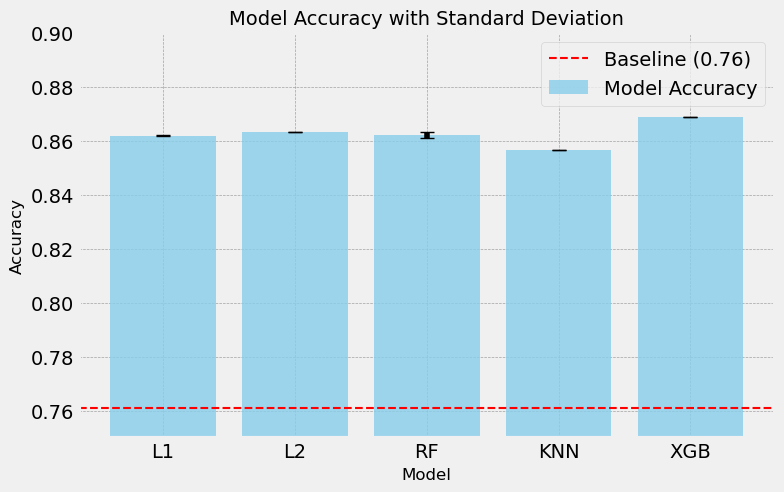

In [1237]:
col_name = ["L1", "L2", "RF", "KNN", "XGB"]
baseline = baseline  # Replace with your actual baseline value

# Calculate mean and std for each model
means = test_scores.mean(axis=1)
stds = test_scores.std(axis=1)

# Plot bar chart with error bars
plt.figure(figsize=(8, 5))
plt.bar(col_name, means, yerr=stds, capsize=5, color='skyblue', alpha=0.8, label='Model Accuracy')

# Add baseline line
plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1.5, label=f'Baseline ({baseline:.2f})')

# Add labels, title, and legend
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy with Standard Deviation", fontsize=14)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylim(0.75, 0.9)

# Save and display the plot
plt.savefig("../figures/accuracy_barplot_with_baseline.png", bbox_inches='tight')
plt.show()

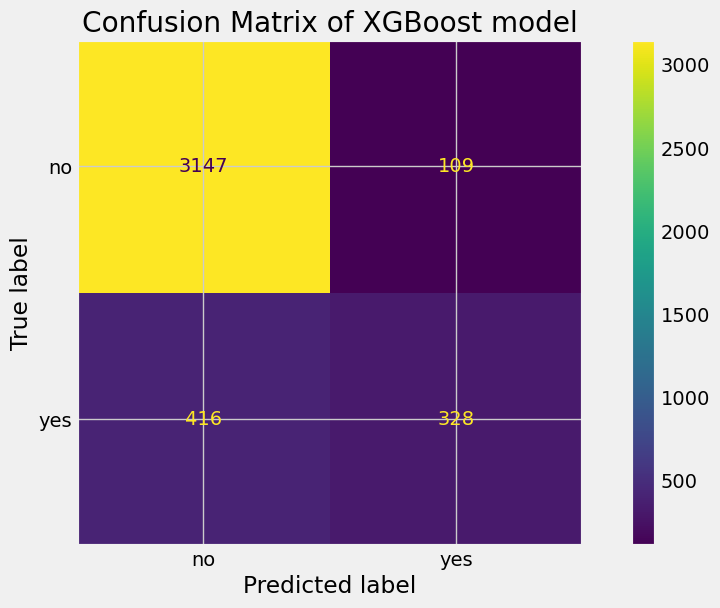

In [1238]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test_d,best_estimator.predict(X_test_prep_d))
disp = ConfusionMatrixDisplay(cm,display_labels=['no', 'yes'])
fig, ax = plt.subplots(figsize=(10,6))
disp.plot(ax=ax)
plt.tight_layout()
plt.title("Confusion Matrix of XGBoost model")
fig.savefig("../figures/confusion_matrix.png",bbox_inches='tight')
plt.show()

In [1239]:
# permutation importance
np.random.seed(42)
ftr_names = X_other.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

y_test_pred = best_estimator.predict(X_test_prep_d)
test_score = accuracy_score(y_test_d,y_test_pred)
print('test score = ',test_score)
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_d.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_d[ftr_names[i]].values)
        X_test_shuffled_prep = preprocessor.transform(X_test_shuffled)
        acc_scores.append(accuracy_score(y_test_d,best_estimator.predict(X_test_shuffled_prep)))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.86875
shuffling Location
   shuffled test score: 0.866 +/- 0.001
shuffling MinTemp
   shuffled test score: 0.866 +/- 0.001
shuffling MaxTemp
   shuffled test score: 0.868 +/- 0.001
shuffling Rainfall
   shuffled test score: 0.865 +/- 0.001
shuffling Evaporation
   shuffled test score: 0.869 +/- 0.001
shuffling Sunshine
   shuffled test score: 0.868 +/- 0.001
shuffling WindGustDir
   shuffled test score: 0.868 +/- 0.001
shuffling WindGustSpeed
   shuffled test score: 0.851 +/- 0.002
shuffling WindDir9am
   shuffled test score: 0.867 +/- 0.001
shuffling WindDir3pm
   shuffled test score: 0.869 +/- 0.001
shuffling WindSpeed9am
   shuffled test score: 0.869 +/- 0.001
shuffling WindSpeed3pm
   shuffled test score: 0.867 +/- 0.001
shuffling Humidity9am
   shuffled test score: 0.867 +/- 0.001
shuffling Humidity3pm
   shuffled test score: 0.799 +/- 0.003
shuffling Pressure9am
   shuffled test score: 0.856 +/- 0.002
shuffling Cloud9am
   shuffled test score: 0.868 +/- 0.001
shuf

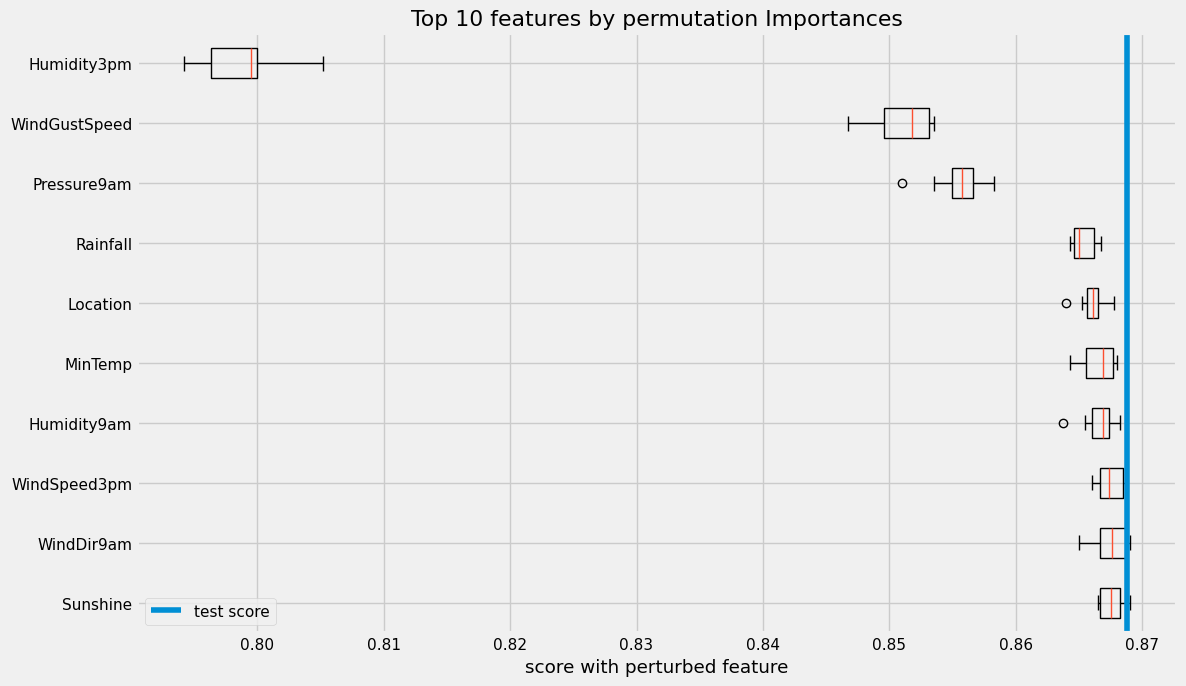

In [1240]:
import matplotlib.pylab as plt
sorted_indcs = np.argsort(np.mean(scores,axis=1))
sorted_indcs = sorted_indcs[:10]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(12,7))
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Top 10 features by permutation Importances")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig("../figures/permutationImportance.png",bbox_inches='tight')
plt.show()


In [1241]:
np.set_printoptions(precision=8)
scores

array([[0.86725, 0.8665 , 0.8655 , 0.86525, 0.8665 , 0.86775, 0.86625,
        0.864  , 0.866  , 0.866  ],
       [0.86575, 0.86775, 0.86425, 0.86475, 0.86725, 0.8655 , 0.8675 ,
        0.868  , 0.8665 , 0.86775],
       [0.86725, 0.86875, 0.86725, 0.86675, 0.8695 , 0.86875, 0.86675,
        0.87   , 0.8665 , 0.86725],
       [0.86675, 0.86425, 0.8645 , 0.8665 , 0.86525, 0.86425, 0.86625,
        0.866  , 0.86475, 0.86475],
       [0.86825, 0.86875, 0.8695 , 0.86925, 0.86925, 0.869  , 0.86775,
        0.8695 , 0.86975, 0.86925],
       [0.8665 , 0.869  , 0.8675 , 0.86825, 0.8675 , 0.86825, 0.867  ,
        0.86825, 0.8665 , 0.8665 ],
       [0.86575, 0.868  , 0.868  , 0.866  , 0.8685 , 0.86625, 0.8675 ,
        0.86925, 0.8675 , 0.86875],
       [0.85275, 0.84675, 0.85125, 0.848  , 0.8535 , 0.85125, 0.85325,
        0.849  , 0.8535 , 0.85225],
       [0.86725, 0.8685 , 0.865  , 0.86875, 0.86875, 0.8665 , 0.867  ,
        0.866  , 0.868  , 0.869  ],
       [0.86925, 0.8695 , 0.86925, 0.

In [1242]:
scores

array([[0.86725, 0.8665 , 0.8655 , 0.86525, 0.8665 , 0.86775, 0.86625,
        0.864  , 0.866  , 0.866  ],
       [0.86575, 0.86775, 0.86425, 0.86475, 0.86725, 0.8655 , 0.8675 ,
        0.868  , 0.8665 , 0.86775],
       [0.86725, 0.86875, 0.86725, 0.86675, 0.8695 , 0.86875, 0.86675,
        0.87   , 0.8665 , 0.86725],
       [0.86675, 0.86425, 0.8645 , 0.8665 , 0.86525, 0.86425, 0.86625,
        0.866  , 0.86475, 0.86475],
       [0.86825, 0.86875, 0.8695 , 0.86925, 0.86925, 0.869  , 0.86775,
        0.8695 , 0.86975, 0.86925],
       [0.8665 , 0.869  , 0.8675 , 0.86825, 0.8675 , 0.86825, 0.867  ,
        0.86825, 0.8665 , 0.8665 ],
       [0.86575, 0.868  , 0.868  , 0.866  , 0.8685 , 0.86625, 0.8675 ,
        0.86925, 0.8675 , 0.86875],
       [0.85275, 0.84675, 0.85125, 0.848  , 0.8535 , 0.85125, 0.85325,
        0.849  , 0.8535 , 0.85225],
       [0.86725, 0.8685 , 0.865  , 0.86875, 0.86875, 0.8665 , 0.867  ,
        0.866  , 0.868  , 0.869  ],
       [0.86925, 0.8695 , 0.86925, 0.

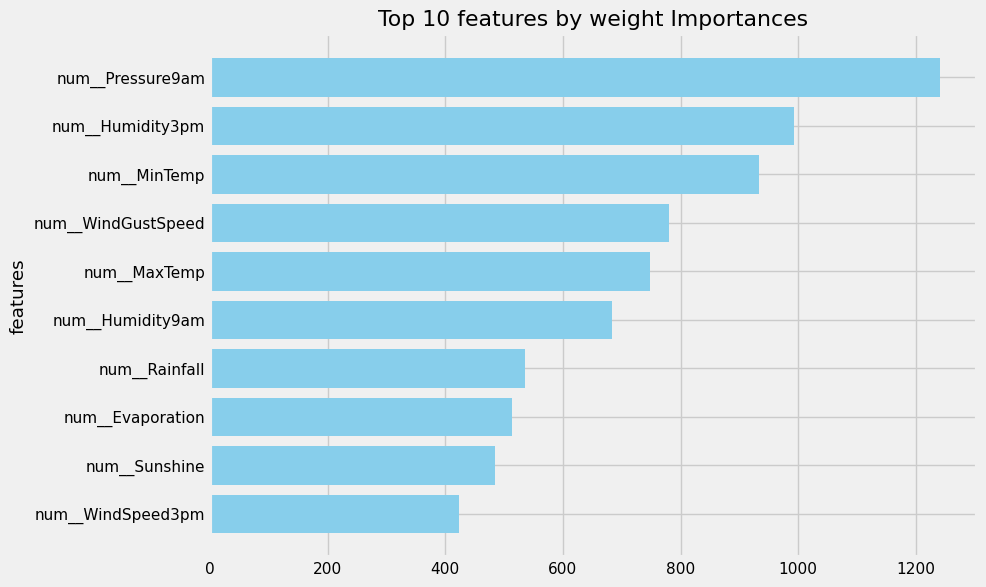

In [1254]:
f = 'weight'
scores_dict = best_estimator.get_booster().get_score(importance_type= f)
#sorted_indcs = np.argsort(np.mean(scores,axis=1))
#sorted_indcs = sorted_indcs[-10:]
ftr_names = preprocessor.get_feature_names_out()
scores = np.array(list(scores_dict.values()))
sorted_indcs = np.argsort(scores)[-10:]
#sorted_indcs = sorted_indcs[-10:]
plt.figure(figsize=(10,6))
plt.barh(width=scores[sorted_indcs],y=ftr_names[sorted_indcs],color='skyblue')
#plt.axvline(test_score,label='test score')
plt.title("Top 10 features by "+f+" Importances")
plt.ylabel('features')
plt.tight_layout()
plt.savefig("../figures/weight_importance.png")
plt.show()

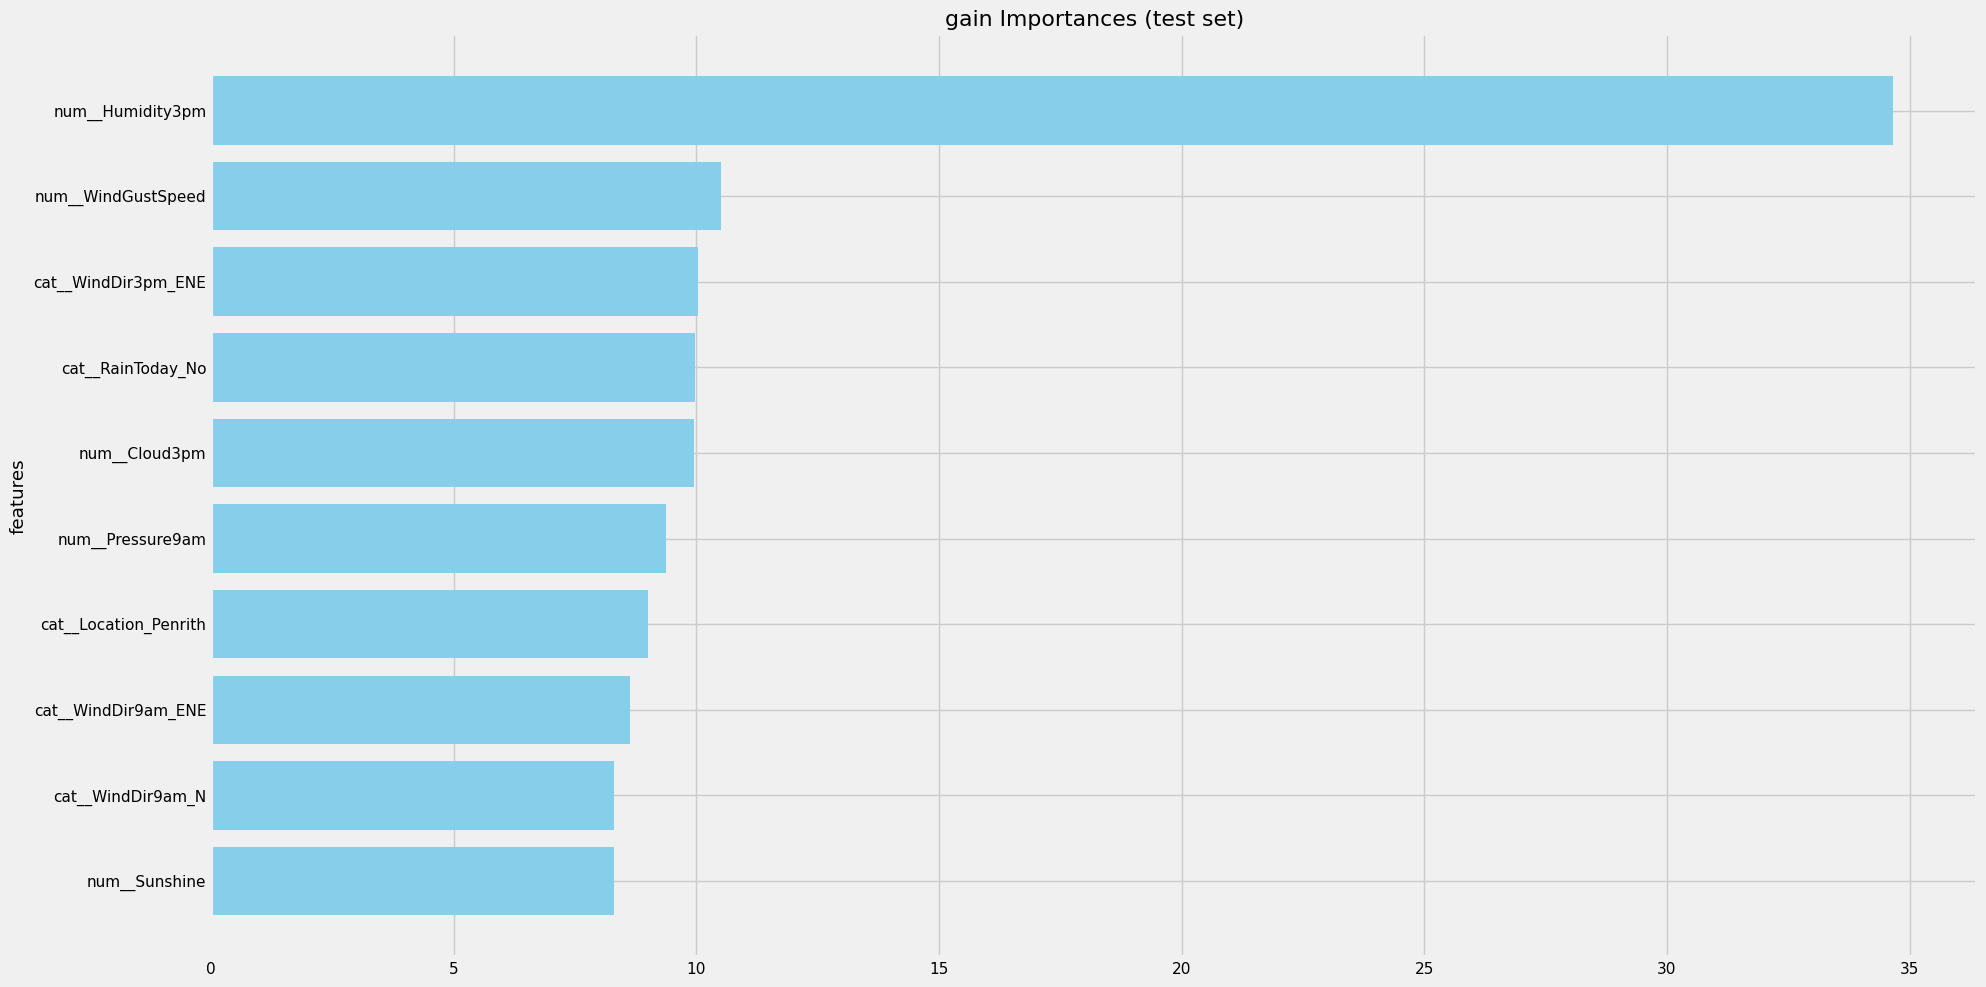

In [1244]:
f = 'gain'
scores_dict = best_estimator.get_booster().get_score(importance_type= f)
#sorted_indcs = np.argsort(np.mean(scores,axis=1))
#sorted_indcs = sorted_indcs[-10:]
ftr_names = preprocessor.get_feature_names_out()
scores = np.array(list(scores_dict.values()))
sorted_indcs = np.argsort(scores)[-10:]
#sorted_indcs = sorted_indcs[-10:]
plt.figure(figsize=(20,10))
plt.barh(width=scores[sorted_indcs],y=ftr_names[sorted_indcs],color='skyblue')
#plt.axvline(test_score,label='test score')
plt.title(f+" Importances (test set)")
plt.ylabel('features')
plt.tight_layout()
plt.show()

In [1245]:
import shap
shap.initjs() # required for visualizations later on
explainer = shap.TreeExplainer(best_estimator)
explanation= explainer(X_test_prep_d)
shap_values = explanation.values

In [1246]:
shap_values.shape

(4000, 116)

In [1247]:
index = 200
proba = best_estimator.predict_proba(X_test_prep_d)[index]
print(proba)

[0.96520597 0.03479402]


In [1248]:
shap_values.shape

(4000, 116)

In [1249]:
# your code here
plt.figure(figsize=(20, 10))
print(explainer.expected_value) # we explain class 0 predictions! Change indices to 1 if you want to explain class 1 predictions!

shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test_prep_d[index,:],feature_names = preprocessor.get_feature_names_out())

-0.95791507


<Figure size 2000x1000 with 0 Axes>

In [1250]:
1/(1+np.exp(3.32))

0.03489140853173684

In [1251]:
shap_mean_abs = abs(shap_values).mean(axis=0)

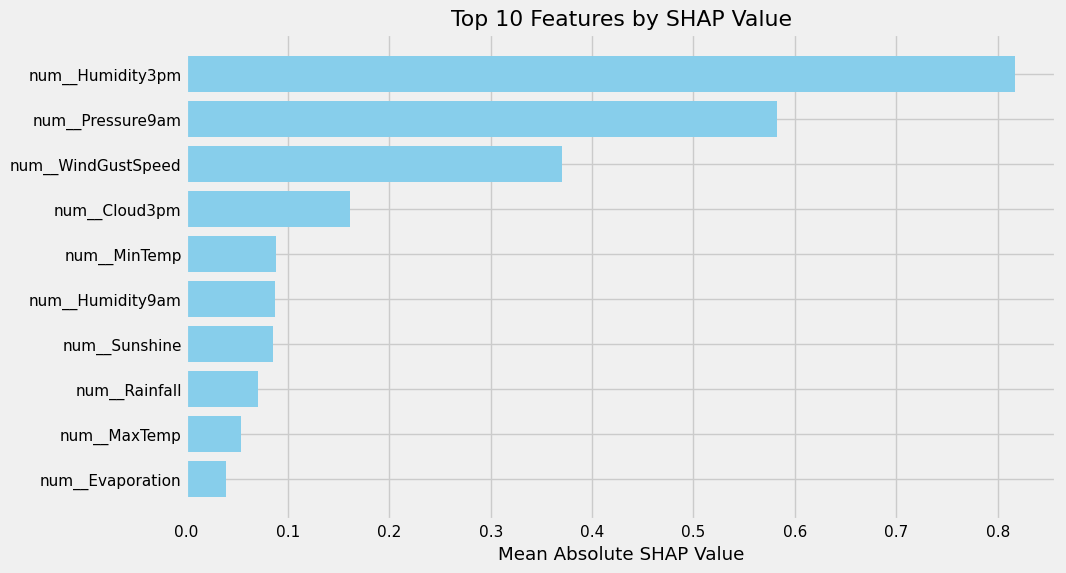

In [1253]:
feature_importance = list(zip(preprocessor.get_feature_names_out(), shap_mean_abs))

# Sort the features by SHAP value in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Get the top 10 features
top_10_features = sorted_features[:10]

# Unzip the sorted top 10 features and their SHAP values
top_10_names, top_10_shap_values = zip(*top_10_features)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_names, top_10_shap_values, color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 10 Features by SHAP Value')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig("../figures/shap_importance.png",bbox_inches='tight')
plt.show()